In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear,tanh
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from ML_util import *
import graphviz
from sklearn.tree import export_graphviz

2022-11-11 02:46:58.518890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_fwf('data.txt')

In [3]:
df.head()

,classID,mX,mXgam,EX_P_Egam,Epis_D__E,Egam,p3L,cospisXga,cospisXga.1,mpisXgam_,...,mcWrongB_.2,mcWrongB_.3,p3pisXgam,cosPhiG1,cospisXga.2,mQXGLw1,weight.1,BDT,LD,prob_LD
0,1,1.114384,1.597457,0.798955,0.104918,0.436953,1.091541,0.898671,0.481301,0.152195,...,3,9,1.567320,-0.883678,0.665655,2.868947,1,-0.079379,0.208172,0.371287
1,1,1.177904,1.341360,-0.089273,0.099872,0.105646,2.069337,0.936480,-0.637876,0.145648,...,4,2,1.593726,0.895740,-0.684525,4.146674,1,-0.325572,0.118564,0.096730
2,1,1.663765,1.745303,1.778954,0.074090,0.157005,1.576703,0.981503,-0.996979,0.144828,...,0,0,1.206983,0.484229,-0.274443,4.848612,1,-0.268796,0.213469,0.393971
3,1,1.364490,1.630229,0.961167,0.101604,0.367103,1.109098,0.954375,-0.810736,0.148047,...,0,0,0.668911,0.629448,0.678082,3.397122,1,-0.238372,0.207760,0.369545
4,1,0.933839,1.396383,0.544535,0.096198,0.333259,1.117779,0.712742,-0.667636,0.145053,...,4,2,0.841355,-0.616161,0.054056,3.099767,1,-0.352616,0.075289,0.049626


In [4]:
df.shape

(178672, 37)

# Load data

In [5]:
X = df.iloc[:,1:]
Y = df.iloc[:,0]

# Clean the data, remove redundant features

In [6]:
X_clean = X.drop(columns = ['weight','weight.1','__run__','__event__','__candida'])

In [7]:
x = X_clean.values  # load the input
y = Y.values # load the target

In [8]:
x.shape

(178672, 31)

In [9]:
y.shape

(178672,)

# Define the normalization function

# The distribution of all features for both zero and one signals.

In [10]:
x0 = x[y==0]
y0 = y[y==0]
print("number of zeros = ", y0.shape[0])

x1 = x[y==1]
y1 = y[y==1]
print("number of ones = ", y1.shape[0])

number of zeros =  14749
number of ones =  163923


In [11]:
n = x0.shape[1]

In [12]:
coa = np.array(X_clean.columns.tolist())

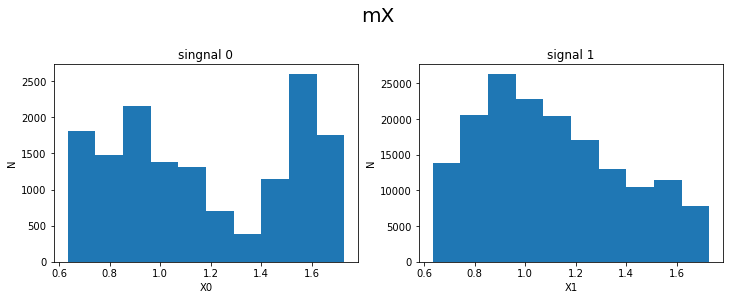

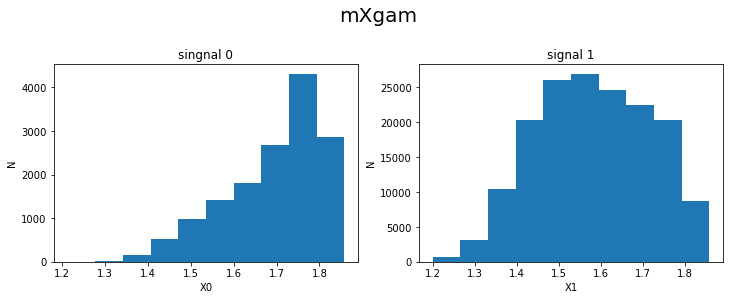

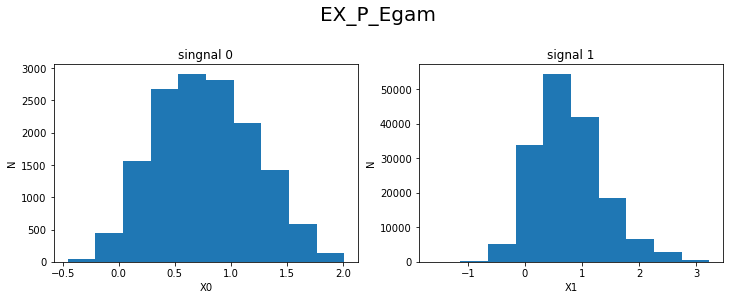

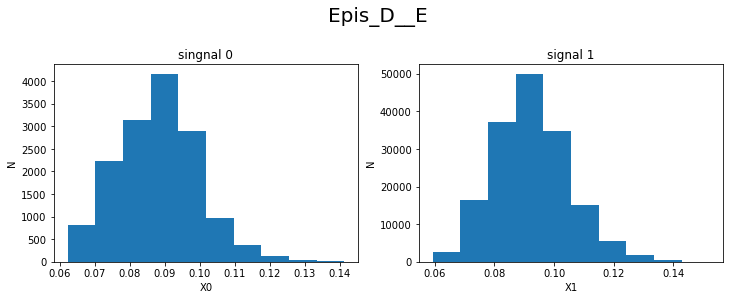

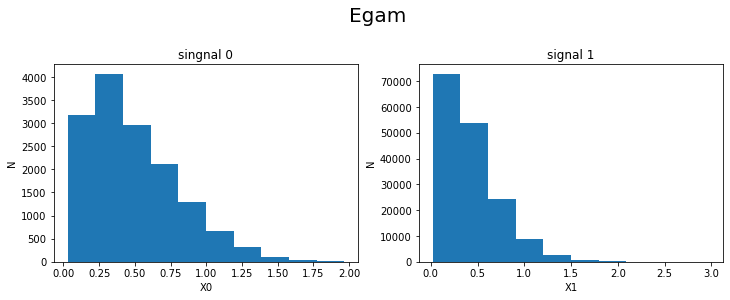

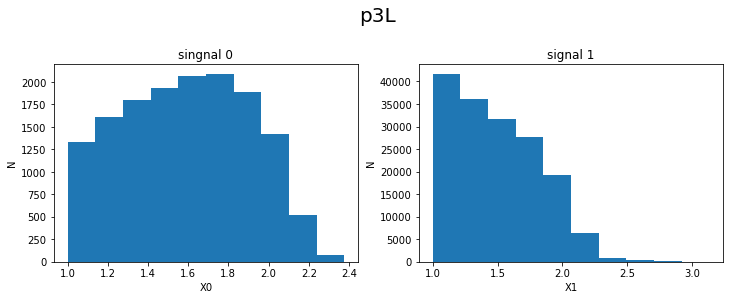

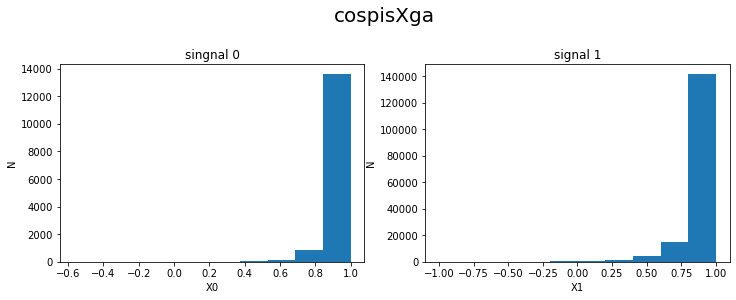

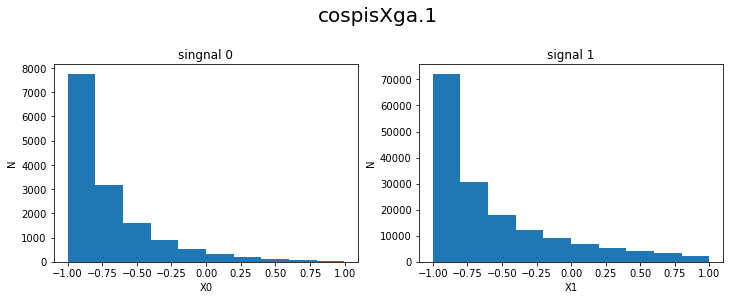

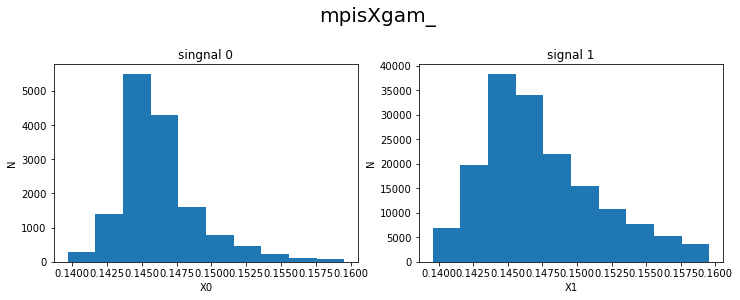

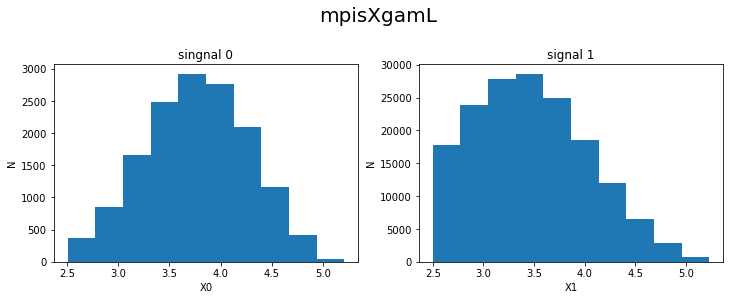

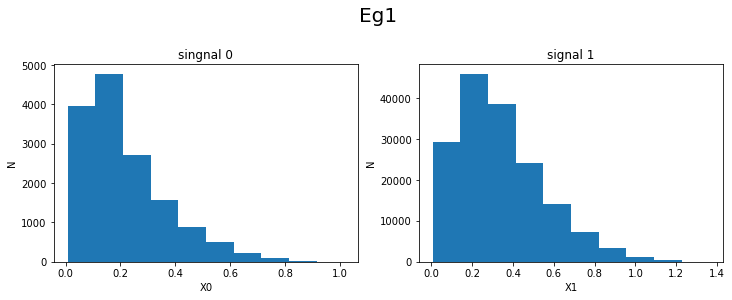

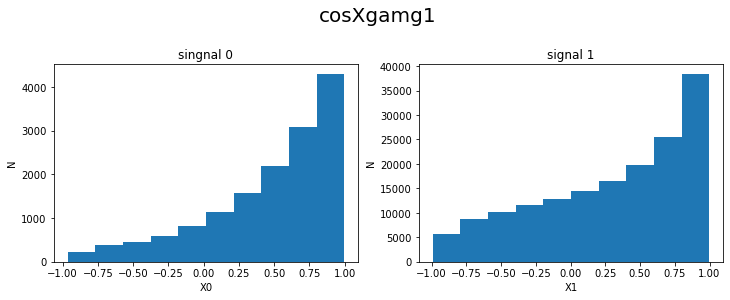

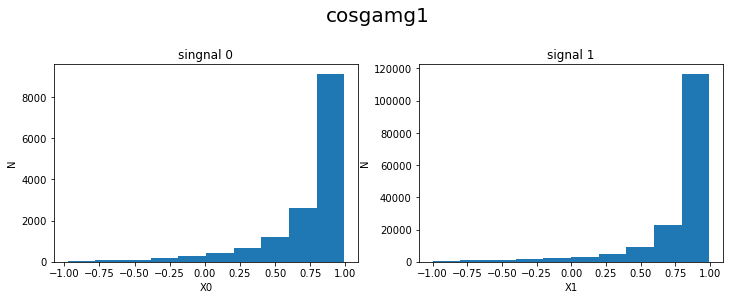

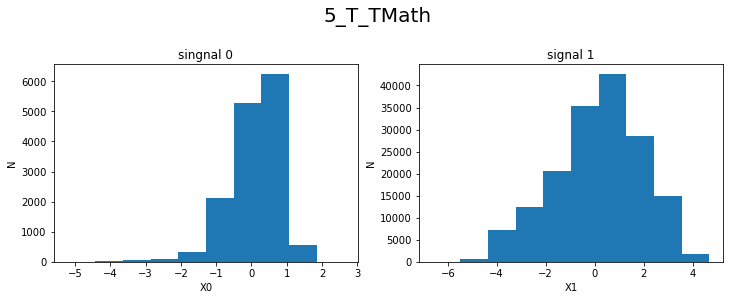

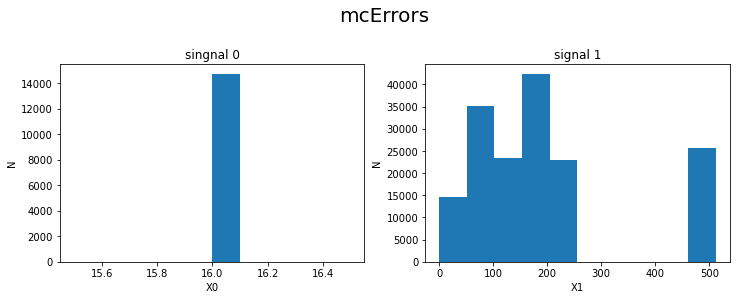

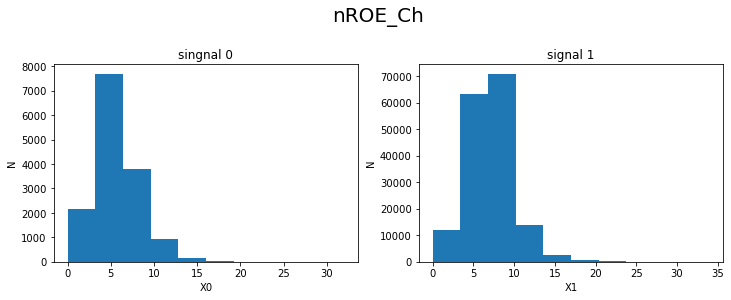

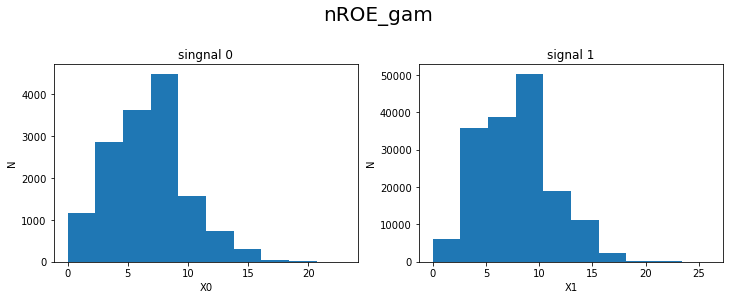

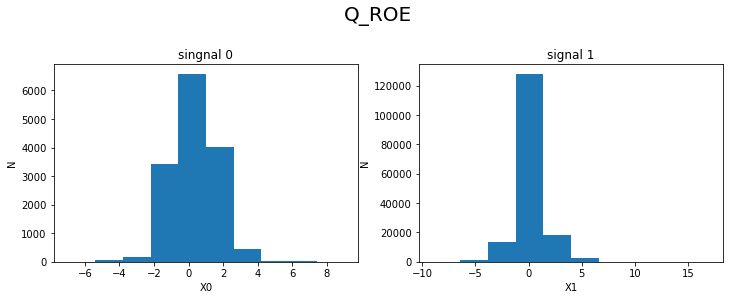

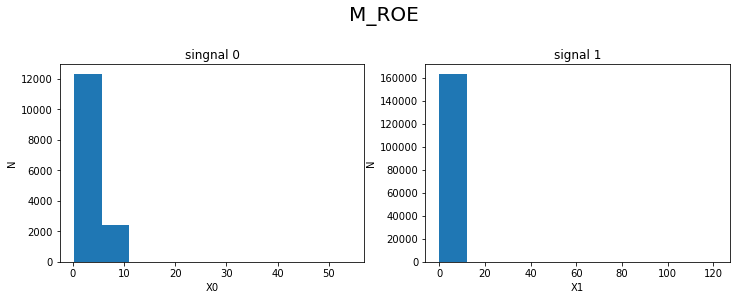

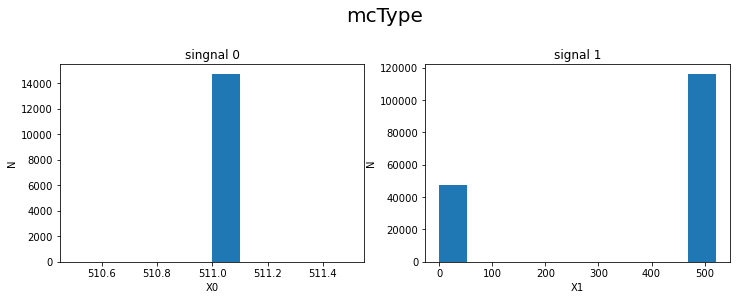

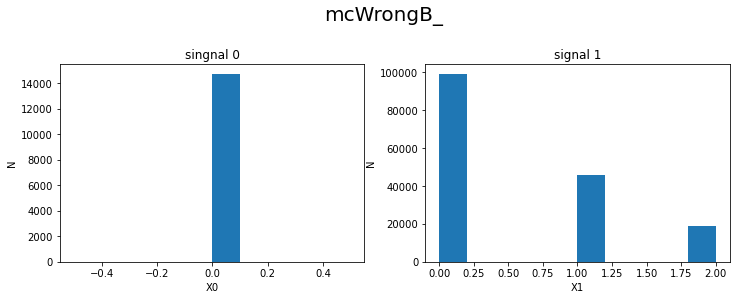

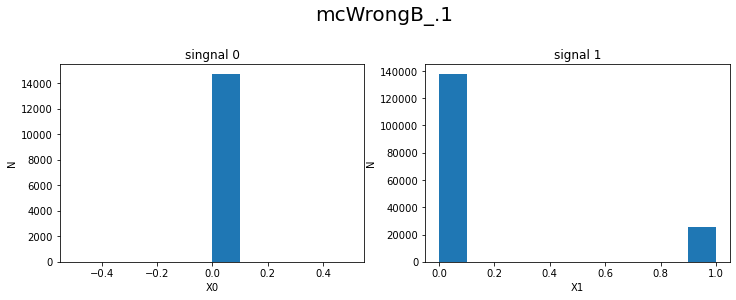

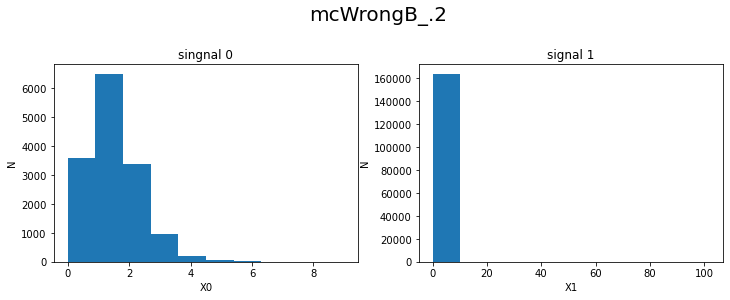

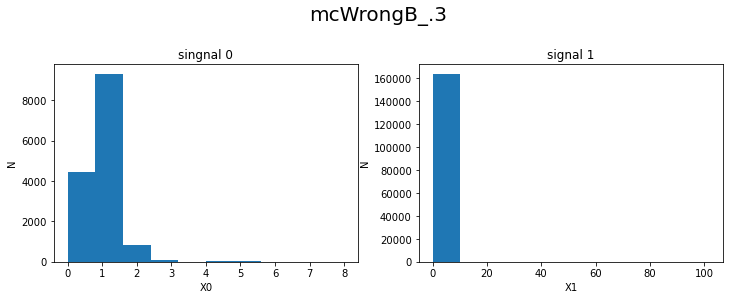

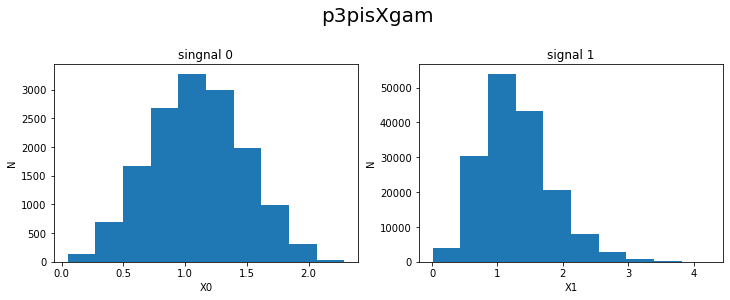

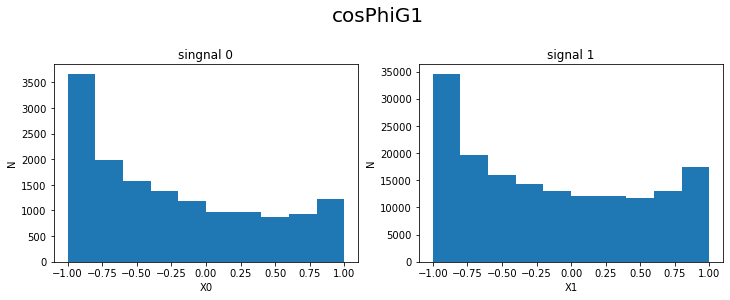

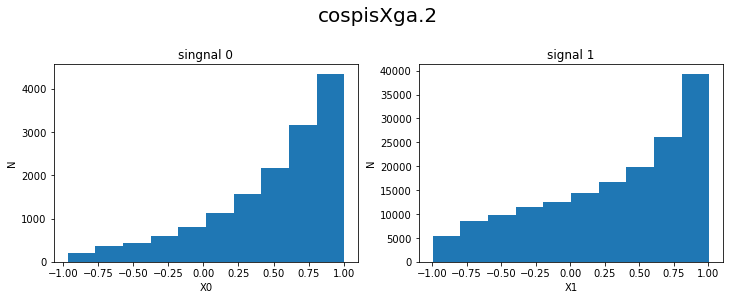

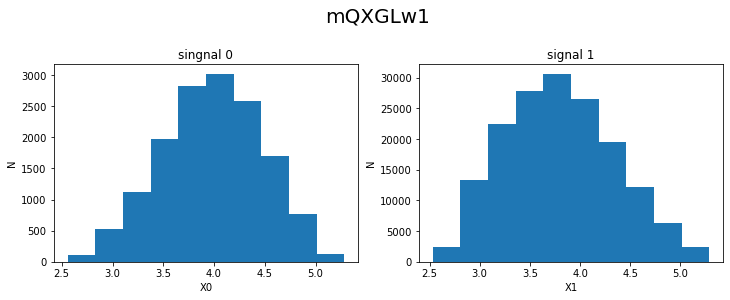

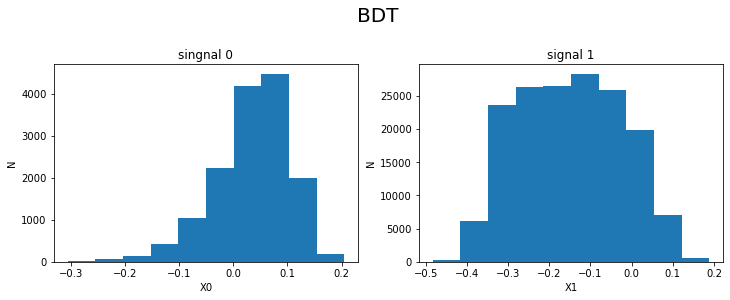

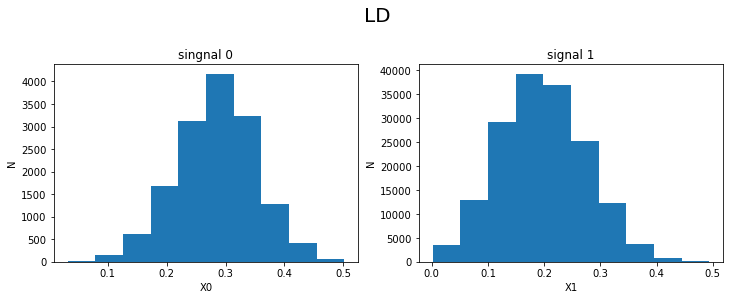

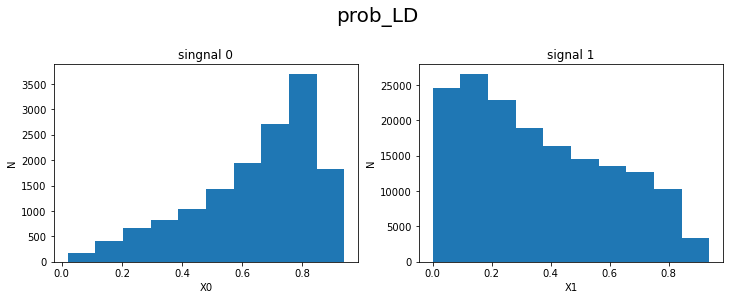

In [13]:
for i in range(n):
    plt.figure(figsize=(12, 8))
    plt.suptitle(coa[i],size =20)
    plt.subplot(2,2, 1)
    plt.hist(x0[:,i])
    plt.title('singnal 0')
    plt.ylabel('N')
    plt.xlabel("X0")


    plt.subplot(2,2,2)
    plt.hist(x1[:,i])
    plt.title('signal 1')
    plt.ylabel('N')
    plt.xlabel("X1")
    plt.show()

## Notice: some features (such as 'mcErrors', 'mcWrongB_', 'mcWrongB_.3', 'BDT') have very distinct distributions for 0-1 signals, which are considered as main features in making classification 

In [14]:
xx,yy = NearMiss().fit_resample(x,y)

In [15]:
np.mean(yy==0)

0.5

# Applying RandomForrest

In [16]:
xx_tr,xx_te,yy_tr, yy_te = train_test_split(xx,yy,test_size = 0.2)

sc = StandardScaler()
xx_tr_S = sc.fit_transform(xx_tr)
xx_te_S = sc.transform(xx_te)

MM = MinMaxScaler()
xx_tr_M = MM.fit_transform(xx_tr)
xx_te_M = MM.transform(xx_te)

In [17]:
RFclass = RandomForestClassifier( criterion='gini',max_depth = 20,min_samples_leaf=10,max_features='auto')

RFmodel = RFclass.fit(xx_tr_S, yy_tr)

Py_tr_prob = RFmodel.predict_proba(xx_tr_S)
Py_tr = RFmodel.predict(xx_tr_S)

Py_te_prob = RFmodel.predict_proba(xx_te_S)
Py_te = RFmodel.predict(xx_te_S)

In [18]:
ys = Y.replace({1:'detect',0:'non-detect'})

In [19]:
estimator = RFmodel.estimators_[5]
dot_data = export_graphviz(estimator, out_file = 'RF.dot', feature_names = coa\
                    ,class_names = sorted(ys.unique()), rounded = True, filled = True)

s = graphviz.Source.from_file('RF.dot')

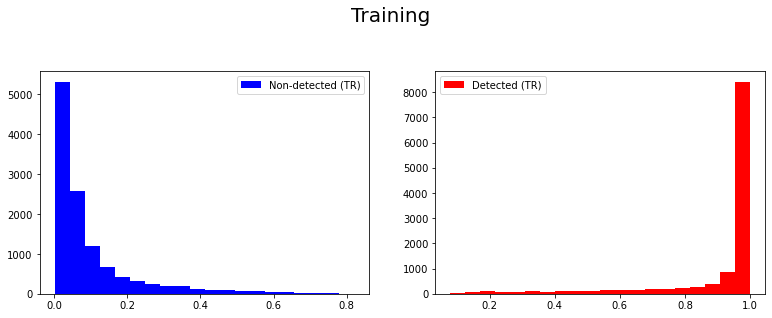

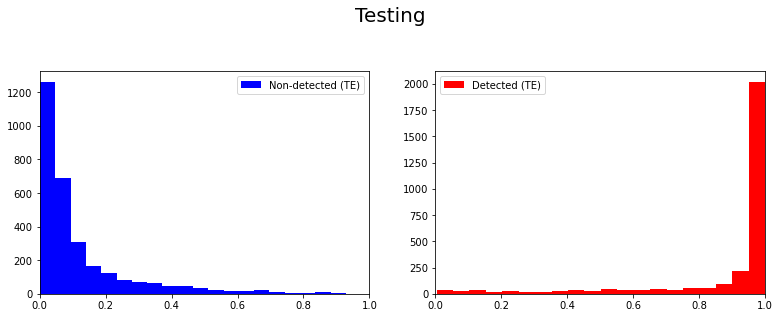

In [20]:
fig = plt.figure(figsize=(13, 9))
plt.suptitle('Training',size =20)
plt.subplot(2, 2, 1)
plt.hist(Py_tr_prob[np.where(yy_tr == 0)[0],1],20,color = "blue",)
plt.legend(['Non-detected (TR)'])

plt.subplot(2, 2, 2)
plt.hist(Py_tr_prob[np.where(yy_tr == 1)[0],1],20,color = "red",)
plt.legend(['Detected (TR)'])
plt.show()


fig = plt.figure(figsize=(13, 9))
plt.suptitle('Testing',size =20)
plt.subplot(2, 2, 1)
plt.hist(Py_te_prob[np.where(yy_te == 0)[0],1],20,color = "blue",)
plt.xlim([0,1])
plt.legend(['Non-detected (TE)'])

plt.subplot(2, 2, 2)
plt.hist(Py_te_prob[np.where(yy_te == 1)[0],1],20,color = "red",)
plt.xlim([0,1])
plt.legend(['Detected (TE)'])
plt.show()

Text(0.5, 1.0, 'Area Under the Curve = 0.993')

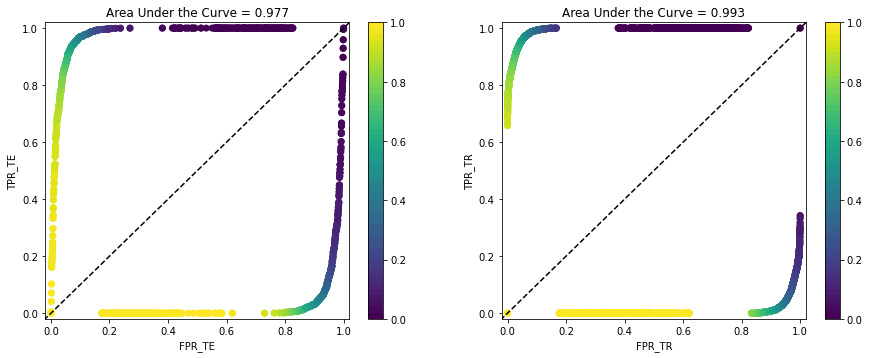

In [21]:
fpr_te = dict()
tpr_te = dict()
T_te = dict()
roc_auc_te = dict()

for i in range(2):
    tpr_te[i], fpr_te[i], T_te[i] = roc_curve(yy_te, Py_te_prob[:,i])
    roc_auc_te[i] = auc(fpr_te[i], tpr_te[i])
    
fig = plt.figure(figsize=(15, 12))


plt.subplot(2, 2, 1)
cmap = plt.cm.get_cmap("viridis",50)
plt.scatter(fpr_te[1], tpr_te[1], c=T_te[1],cmap=cmap,vmin=0.,vmax=1)
plt.scatter(fpr_te[0], tpr_te[0], c=T_te[0],cmap=cmap,vmin=0.,vmax=1)
plt.colorbar()
plt.plot([-0.2,1.2],[-0.2,1.2], '--k')
plt.xlim([-.02,1.02])
plt.ylim([-.02,1.02])

plt.xlabel('FPR_TE')
plt.ylabel('TPR_TE')
plt.title('Area Under the Curve = %.3f' %roc_auc_te[0])



fpr_tr = dict()
tpr_tr = dict()
T_tr = dict()
roc_auc_tr = dict()

for i in range(2):
    tpr_tr[i], fpr_tr[i], T_tr[i] = roc_curve(yy_tr, Py_tr_prob[:,i])
    roc_auc_tr[i] = auc(fpr_tr[i], tpr_tr[i])


plt.subplot(2, 2, 2)
cmap = plt.cm.get_cmap("viridis",50)
plt.scatter(fpr_tr[1], tpr_tr[1], c=T_tr[1],cmap=cmap,vmin=0.,vmax=1)
plt.scatter(fpr_tr[0], tpr_tr[0], c=T_tr[0],cmap=cmap,vmin=0.,vmax=1)
plt.colorbar()
plt.plot([-0.2,1.2],[-0.2,1.2], '--k')
plt.xlim([-.02,1.02])
plt.ylim([-.02,1.02])

plt.xlabel('FPR_TR')
plt.ylabel('TPR_TR') 
plt.title('Area Under the Curve = %.3f' %roc_auc_tr[0])


Normalized confusion matrix
[[0.98 0.02]
 [0.07 0.93]]


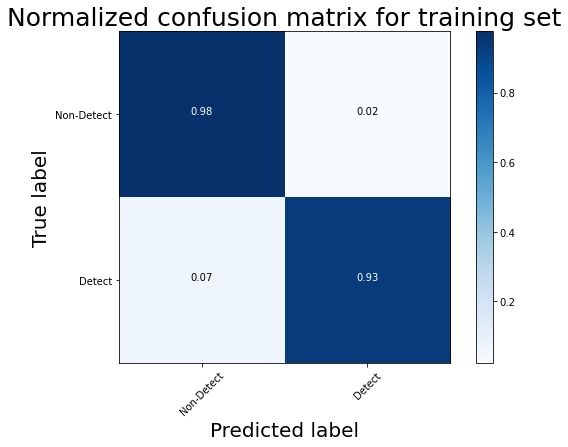

In [22]:
cnf_matrix = confusion_matrix(yy_tr,Py_tr)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Non-Detect', 'Detect'], normalize=True,
                      title='Normalized confusion matrix for training set')

plt.show()

Normalized confusion matrix
[[0.96 0.04]
 [0.09 0.91]]


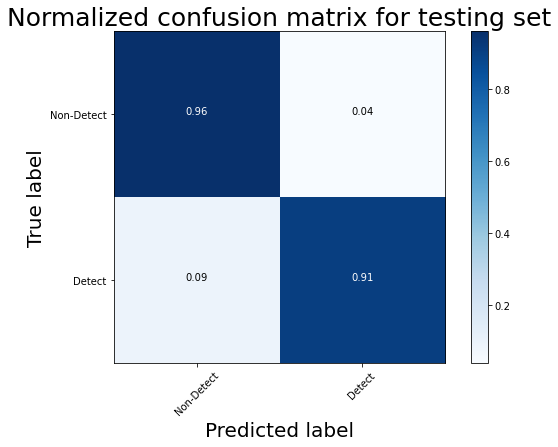

In [23]:
cnf_matrix = confusion_matrix(yy_te,Py_te)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Non-Detect', 'Detect'], normalize=True,
                      title='Normalized confusion matrix for testing set')

plt.show()

In [24]:
importance = pd.DataFrame(RFclass.feature_importances_)
importance = importance.set_index(coa)
importance = importance.set_axis(['weight'], axis=1)

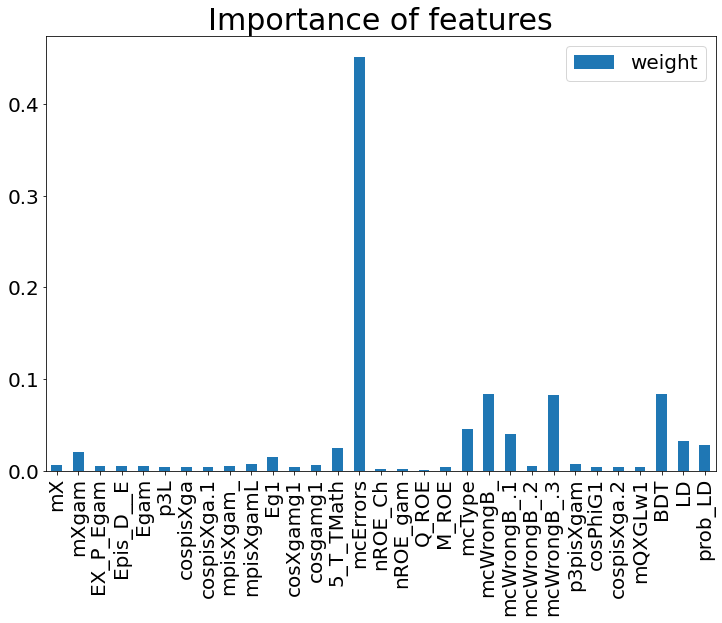

In [25]:
importance.plot(kind='bar',figsize=(12,8),fontsize = 20)
plt.title('Importance of features',size = 30)
plt.legend(fontsize = 20)
plt.show()

# Select significant features

In [26]:
nf =importance.loc[(importance['weight']>0.01)]

In [27]:
nfa = nf.index.values

In [28]:
nfa

array(['mXgam', 'Eg1', '5_T_TMath', 'mcErrors', 'mcType', 'mcWrongB_',
       'mcWrongB_.1', 'mcWrongB_.3', 'BDT', 'LD', 'prob_LD'], dtype=object)

In [29]:
x_n= df[nfa]

In [30]:
x_n.shape

(178672, 11)

In [31]:
nidx = np.array([X_clean.columns.get_loc(i) for i in nfa])

In [32]:
xn = xx[:,nidx]

# Training Neutral Network

In [33]:
x_tr,x_te,y_tr, y_te = train_test_split(x_n.values,y,test_size = 0.4, shuffle=True)
x_cv,x_te,y_cv, y_te = train_test_split(x_te,y_te,test_size = 0.5, shuffle=True)

In [34]:
sc = StandardScaler()
x_tr_S = sc.fit_transform(x_tr)
x_cv_S = sc.transform(x_cv)
x_te_S = sc.transform(x_te)

#xn_tr_S = sc.transform(xn_tr)
#xn_te_S = sc.transform(xn_te)

MM = MinMaxScaler()
x_tr_M = MM.fit_transform(x_tr)
x_cv_M = MM.transform(x_cv)
x_te_M = MM.transform(x_te)

#xn_tr_M = MM.transform(xn_tr)
#xn_te_M = MM.transform(xn_te)

In [35]:
print("x_tr.shape:", x_tr.shape, "x_cv.shape:", x_cv.shape, "x_te.shape:", x_te.shape)

x_tr.shape: (107203, 11) x_cv.shape: (35734, 11) x_te.shape: (35735, 11)


In [36]:
model_A = Sequential([                     #a shallow model with relu activation in hidden layers
    tf.keras.Input(shape=(x_tr.shape[1],)),  
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="linear"),
    ] ,name = "Signal_classifier_A" )

model_A.compile(loss = BinaryCrossentropy(from_logits=True),optimizer = Adam(5e-4),metrics=['accuracy'])

2022-11-11 02:48:10.174722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
model_B = Sequential([                     #a shallow model with sigmoid activation in hidden layers
    tf.keras.Input(shape=(x_tr.shape[1],)),  
    Dense(32, activation="sigmoid"),
    Dense(16, activation="sigmoid"),
    Dense(1, activation="linear"),
    ] ,name = "Signal_classifier_B" )

model_B.compile(loss = BinaryCrossentropy(from_logits=True),optimizer = Adam(5e-4),metrics=['accuracy'])

In [38]:
model_C = Sequential([                     #a deep model with relu activation in hidden layers
    tf.keras.Input(shape=(x_tr.shape[1],)),  
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="linear"),
    ] ,name = "Signal_classifier_C" )

model_C.compile(loss = BinaryCrossentropy(from_logits=True),optimizer = Adam(5e-4),metrics=['accuracy'])

In [39]:
model_D = Sequential([                     
    tf.keras.Input(shape=(x_tr.shape[1],)),  
    Dense(1, activation="linear"),        #a logistic regression model
    ] ,name = "Signal_classifier_D" )

model_D.compile(loss = BinaryCrossentropy(from_logits=True),optimizer = Adam(5e-4),metrics=['accuracy'])

In [40]:
batch_size,epoch = 64,50

In [41]:
history_A = model_A.fit(x_tr_S, y_tr, batch_size = batch_size, epochs = epoch,shuffle=True)

Epoch 1/50
1676/1676 [==============================] - 2s 867us/step - loss: 0.1183 - accuracy: 0.9385
Epoch 2/50
1676/1676 [==============================] - 1s 859us/step - loss: 0.0472 - accuracy: 0.9814
Epoch 3/50
1676/1676 [==============================] - 1s 863us/step - loss: 0.0393 - accuracy: 0.9849
Epoch 4/50
1676/1676 [==============================] - 1s 891us/step - loss: 0.0358 - accuracy: 0.9859
Epoch 5/50
1676/1676 [==============================] - 1s 870us/step - loss: 0.0342 - accuracy: 0.9863
Epoch 6/50
1676/1676 [==============================] - 1s 848us/step - loss: 0.0333 - accuracy: 0.9867
Epoch 7/50
1676/1676 [==============================] - 1s 855us/step - loss: 0.0329 - accuracy: 0.9866
Epoch 8/50
1676/1676 [==============================] - 1s 863us/step - loss: 0.0325 - accuracy: 0.9866
Epoch 9/50
1676/1676 [==============================] - 1s 872us/step - loss: 0.0323 - accuracy: 0.9868
Epoch 10/50
1676/1676 [==============================] - 2s 898u

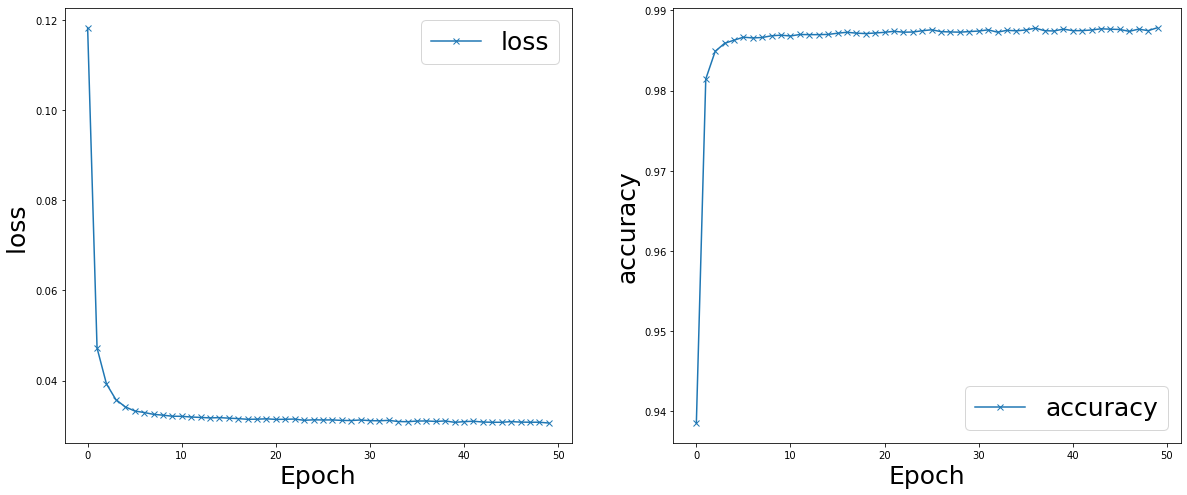

In [42]:
plot_loss_tf(history_A)

In [43]:
history_B = model_B.fit(x_tr_S, y_tr, batch_size = batch_size, epochs = epoch,shuffle=True)

Epoch 1/50
1676/1676 [==============================] - 2s 947us/step - loss: 0.2477 - accuracy: 0.8766
Epoch 2/50
1676/1676 [==============================] - 1s 893us/step - loss: 0.0949 - accuracy: 0.9666
Epoch 3/50
1676/1676 [==============================] - 1s 887us/step - loss: 0.0615 - accuracy: 0.9739
Epoch 4/50
1676/1676 [==============================] - 2s 923us/step - loss: 0.0498 - accuracy: 0.9803
Epoch 5/50
1676/1676 [==============================] - 2s 938us/step - loss: 0.0436 - accuracy: 0.9837
Epoch 6/50
1676/1676 [==============================] - 2s 937us/step - loss: 0.0405 - accuracy: 0.9852
Epoch 7/50
1676/1676 [==============================] - 2s 958us/step - loss: 0.0387 - accuracy: 0.9858
Epoch 8/50
1676/1676 [==============================] - 2s 929us/step - loss: 0.0376 - accuracy: 0.9861
Epoch 9/50
1676/1676 [==============================] - 2s 932us/step - loss: 0.0368 - accuracy: 0.9864
Epoch 10/50
1676/1676 [==============================] - 2s 969u

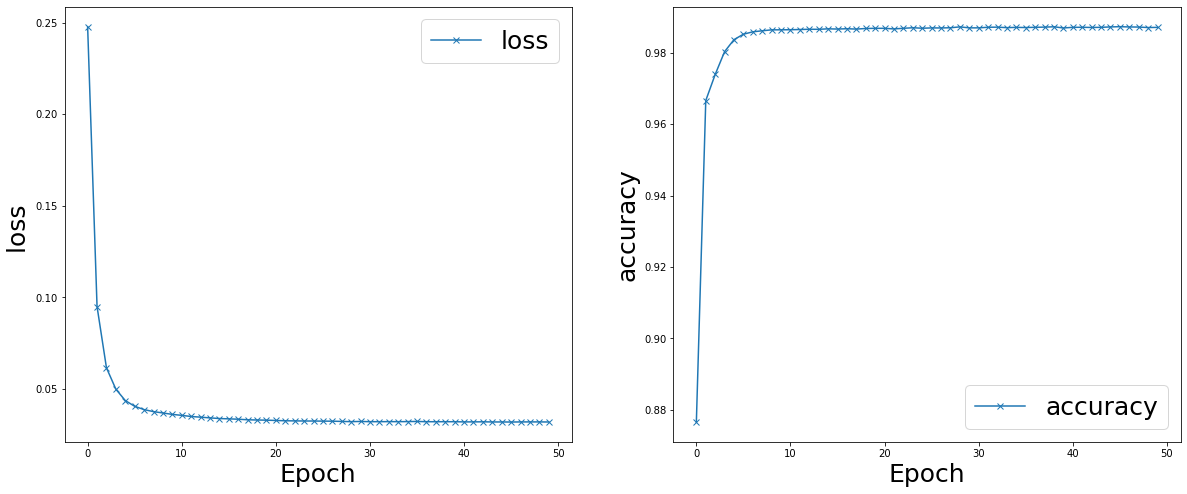

In [44]:
plot_loss_tf(history_B)

In [45]:
history_C = model_C.fit(x_tr_S, y_tr, batch_size = batch_size, epochs = epoch,shuffle=True)

Epoch 1/50
1676/1676 [==============================] - 2s 1ms/step - loss: 0.0787 - accuracy: 0.9653
Epoch 2/50
1676/1676 [==============================] - 2s 975us/step - loss: 0.0386 - accuracy: 0.9850
Epoch 3/50
1676/1676 [==============================] - 2s 939us/step - loss: 0.0348 - accuracy: 0.9861
Epoch 4/50
1676/1676 [==============================] - 2s 999us/step - loss: 0.0336 - accuracy: 0.9867
Epoch 5/50
1676/1676 [==============================] - 2s 1ms/step - loss: 0.0329 - accuracy: 0.9865
Epoch 6/50
1676/1676 [==============================] - 2s 1ms/step - loss: 0.0327 - accuracy: 0.9869
Epoch 7/50
1676/1676 [==============================] - 2s 1ms/step - loss: 0.0324 - accuracy: 0.9869
Epoch 8/50
1676/1676 [==============================] - 2s 1ms/step - loss: 0.0324 - accuracy: 0.9869
Epoch 9/50
1676/1676 [==============================] - 2s 991us/step - loss: 0.0321 - accuracy: 0.9868
Epoch 10/50
1676/1676 [==============================] - 2s 1ms/step - los

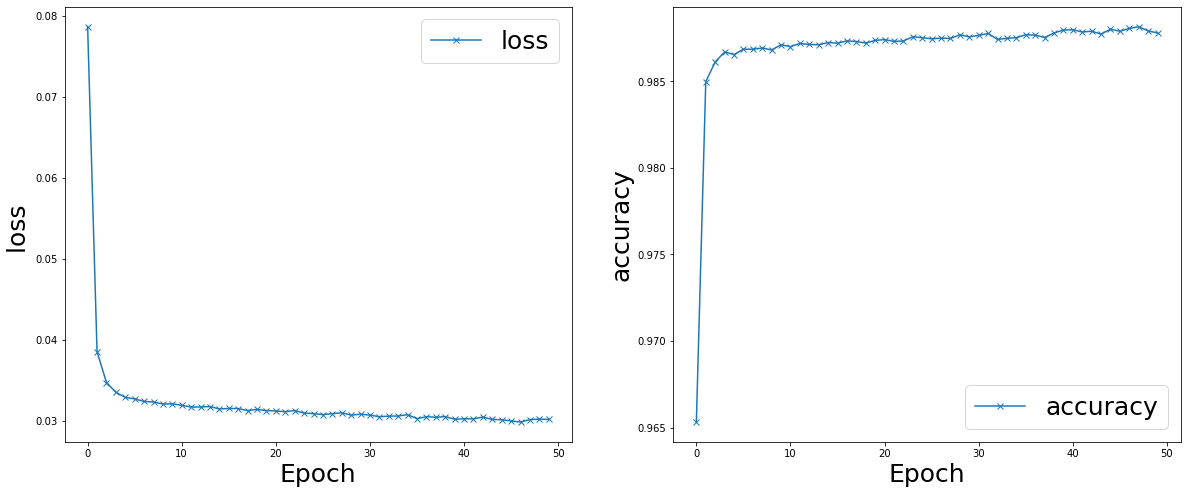

In [46]:
plot_loss_tf(history_C)

In [47]:
history_D = model_D.fit(x_tr_S, y_tr, batch_size = batch_size, epochs = epoch,shuffle=True)

Epoch 1/50
1676/1676 [==============================] - 2s 842us/step - loss: 0.5292 - accuracy: 0.5464
Epoch 2/50
1676/1676 [==============================] - 1s 789us/step - loss: 0.3285 - accuracy: 0.8441
Epoch 3/50
1676/1676 [==============================] - 1s 786us/step - loss: 0.2336 - accuracy: 0.9373
Epoch 4/50
1676/1676 [==============================] - 1s 770us/step - loss: 0.1809 - accuracy: 0.9552
Epoch 5/50
1676/1676 [==============================] - 1s 811us/step - loss: 0.1488 - accuracy: 0.9603
Epoch 6/50
1676/1676 [==============================] - 1s 781us/step - loss: 0.1280 - accuracy: 0.9627
Epoch 7/50
1676/1676 [==============================] - 1s 778us/step - loss: 0.1141 - accuracy: 0.9640
Epoch 8/50
1676/1676 [==============================] - 1s 778us/step - loss: 0.1046 - accuracy: 0.9652
Epoch 9/50
1676/1676 [==============================] - 1s 809us/step - loss: 0.0977 - accuracy: 0.9657
Epoch 10/50
1676/1676 [==============================] - 1s 812u

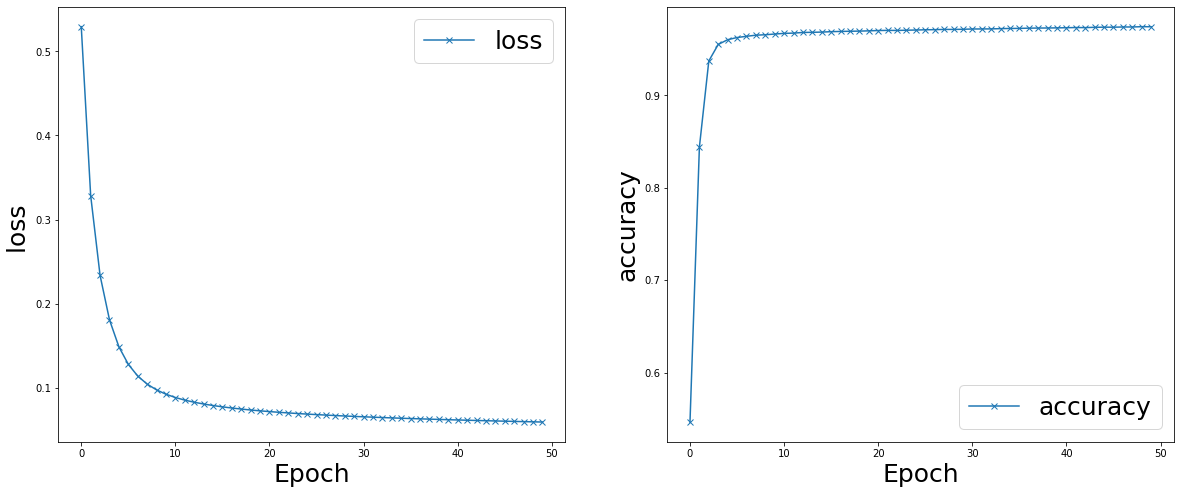

In [48]:
plot_loss_tf(history_D)

# Result of Training

In [49]:
accuracy,recall,precision,Fs = bc_eva(model_A,x_tr_S,y_tr)

3351/3351 [==============================] - 2s 665us/step
model: Signal_classifier_A
accuracy =  0.9883678628396594
recall =  0.9904666944763804
precision =  0.9968257218922794
F-score =  0.9936360342337469


In [50]:
accuracy,recall,precision,Fs = bc_eva(model_B,x_tr_S,y_tr)

3351/3351 [==============================] - 2s 618us/step
model: Signal_classifier_B
accuracy =  0.9875190059979665
recall =  0.9917181315942089
precision =  0.9946528975376797
F-score =  0.9931833465794461


In [51]:
accuracy,recall,precision,Fs = bc_eva(model_C,x_tr_S,y_tr)

3351/3351 [==============================] - 2s 627us/step
model: Signal_classifier_C
accuracy =  0.9885264404914041
recall =  0.9918809201623816
precision =  0.9955882803484442
F-score =  0.9937311424610618


In [52]:
accuracy,recall,precision,Fs = bc_eva(model_D,x_tr_S,y_tr)

3351/3351 [==============================] - 2s 593us/step
model: Signal_classifier_D
accuracy =  0.9782935179052825
recall =  0.9846266545931812
precision =  0.9916386589064677
F-score =  0.9881202170727847


# Validation

In [53]:
accuracy,recall,precision,Fs = bc_eva(model_A,x_cv_S,y_cv)

1117/1117 [==============================] - 1s 692us/step
model: Signal_classifier_A
accuracy =  0.9887781944366709
recall =  0.990752570420393
precision =  0.9970306425444638
F-score =  0.9938816923757648


In [54]:
accuracy,recall,precision,Fs = bc_eva(model_B,x_cv_S,y_cv)

1117/1117 [==============================] - 1s 617us/step
model: Signal_classifier_B
accuracy =  0.988638271674036
recall =  0.9924560442903206
precision =  0.9951805758906784
F-score =  0.9938164427792501


In [55]:
accuracy,recall,precision,Fs = bc_eva(model_C,x_cv_S,y_cv)

1117/1117 [==============================] - 1s 601us/step
model: Signal_classifier_C
accuracy =  0.988750209884144
recall =  0.9915434690028594
precision =  0.9962102689486553
F-score =  0.9938713906759764


In [56]:
accuracy,recall,precision,Fs = bc_eva(model_D,x_cv_S,y_cv)

1117/1117 [==============================] - 1s 608us/step
model: Signal_classifier_D
accuracy =  0.977864218951139
recall =  0.9836344831781956
precision =  0.9922366442664703
F-score =  0.987916838519469


## All models looks good, but model A has highest F-score

$ $

# Test

In [57]:
accuracy,recall,precision,Fs = bc_eva(model_A,x_te_S,y_te)

1117/1117 [==============================] - 1s 611us/step
model: Signal_classifier_A
accuracy =  0.9873233524555758
recall =  0.9897747390269215
precision =  0.9963742510370257
F-score =  0.993063530708806


In [58]:
accuracy,recall,precision,Fs = bc_eva(model_B,x_te_S,y_te)

1117/1117 [==============================] - 1s 574us/step
model: Signal_classifier_B
accuracy =  0.9871554498390933
recall =  0.991514559550699
precision =  0.9944589009643349
F-score =  0.9929845476638085


In [59]:
accuracy,recall,precision,Fs = bc_eva(model_C,x_te_S,y_te)

1117/1117 [==============================] - 1s 586us/step
model: Signal_classifier_C
accuracy =  0.9872673849167483
recall =  0.9907209572065198
precision =  0.9953693765524855
F-score =  0.9930397270961129


In [60]:
accuracy,recall,precision,Fs = bc_eva(model_D,x_te_S,y_te)

1117/1117 [==============================] - 1s 559us/step
model: Signal_classifier_D
accuracy =  0.9774730656219393
recall =  0.9843110921189182
precision =  0.9910568855834537
F-score =  0.9876724705594095
